In [17]:
import pandas as pd
import os
import lxml.etree as et
import graphviz
from graphviz import Graph, Digraph

In [2]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [3]:
class Node:

    def __init__(self, name):
        self.name = name
        self.children = []

In [4]:
def get_raw_entities(root_elem):
    name = root_elem.tag.split('}')[1]
    children = list(root_elem)
    if len(children) != 0:
        attrs = [c.tag.split('}')[1] for c in children]
        if name not in entities:
            entities[name] = attrs
        for c in children:
            get_raw_entities(c)

In [5]:
def get_entities_from_xml():
    get_raw_entities(root[0])
    result = {key:values for key, values in entities.items() if not (key[-1] == 's' and key[:-1] in values)}
    return result

In [6]:
def add_child(parent, child):
    parent.children.append(child)

def translate(entity_name, current_node):
    for attr in entities[entity_name]:
        new_node = Node(attr)
        add_child(current_node, new_node)
        if attr in entities:
            dot.edge(current_node.name, f'{attr}')
            translate(attr, new_node)
        else:
            dot.edge(current_node.name, f'{entity_name[0:3]}_{attr}') # add prefix to node for uniqueness

In [7]:
def graft(parents, node):
    for p in parents:
        for child in entities[node]:
            entities[p].append(child)
        entities[p].remove(node)

In [8]:
def prune(parent, node):
    entities[parent].remove(node)

In [36]:
path = r'fcsNotificationEA44_0119300019817000426_12490609.xml'
tree = et.parse(path)
root = tree.getroot()
entities = {}
entities_names = []
entities = get_entities_from_xml()

In [37]:
multiple = ['customerRequirements', 'kladrPlaces', 'purchaseObjects', 'preferenses', 'requirements', 'attachments']
for k,v in entities.items():
    entities[k] = list(map(lambda x: x[:-1] if x in multiple else x, v))
entities['applicationGuarantee'] = list(map(lambda x: x if x != 'procedureInfo' else 'info', entities['applicationGuarantee'])) 
entities['contractGuarantee'] = list(map(lambda x: x if x != 'procedureInfo' else 'info', entities['contractGuarantee'])) 
graft(['purchaseObject'], 'customerQuantities')
graft(['customerQuantity'], 'quantity')
graft(['reason'], 'responsibleDecision')
graft(['attachment'], 'cryptoSigns')
graft(['kladrPlace'], 'kladr')
graft(['fcsNotificationEF'], 'printForm')
prune('purchaseObject', 'quantity')
prune('currency', 'code')
prune('fcsNotificationEF', 'id')
prune('placingWay', 'code')
prune('preferense', 'code')
prune('ETP', 'code')
prune('kladrPlace', 'kladrCode')
prune('attachment', 'publishedContentId')
prune('customerRequirement', 'purchaseCode')
prune('customerRequirement', 'tenderPlanInfo')

In [38]:
root = Node('fcsNotificationEF')
#dot = Graph(comment='Atribute tree', strict=True, engine='fdp')
dot = Digraph(comment='Atribute tree', strict=True, engine='fdp')
dot.attr(size='25,5')
translate('fcsNotificationEF', root)
dot.view() #to open .pdf

'Digraph.gv.pdf'

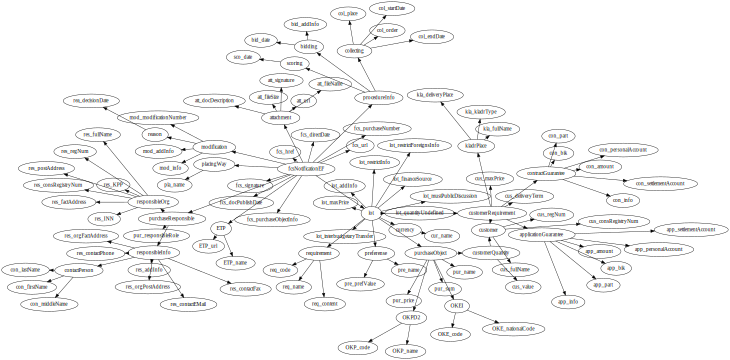

In [39]:
dot